# Bayesian Methods for Better Decision Making

[Bayesian Decision Analysis](https://allendowney.github.io/BayesianDecisionAnalysis/)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Bayesian Bandit problem

Suppose you have several "one-armed bandit" slot machines, and there's reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's choose a data structure.

## Representing a PMF

A probability mass function (PMF) is a sequence of possible outcomes and their probabilities. One good way to represent a PMF is a pandas `Series`.

Here is a `Series` that represents the outcome of a coin toss.

In [80]:
import pandas as pd

xs = ['Heads', 'Tails']
ps = [0.5, 0.5]
pd.Series(ps, xs)

Heads    0.5
Tails    0.5
dtype: float64

Here's a `Series` that represents the outcome of a die roll.

In [81]:
xs = [1,2,3,4,5,6]
ps = 1/6
pd.Series(ps, xs)

1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
6    0.166667
dtype: float64

## The prior

Now we'll make a `Series` that represents possible values of `x` from 0 to 100.

If we know nothing about the probability of winning, we can start with a uniform prior.

In [82]:
xs = np.arange(101)
prior = pd.Series(1/101, xs)

Here are the first few quantities and their probabilities.

In [83]:
prior.head()

0    0.009901
1    0.009901
2    0.009901
3    0.009901
4    0.009901
dtype: float64

And the last few quantities.

In [84]:
prior.tail()

96     0.009901
97     0.009901
98     0.009901
99     0.009901
100    0.009901
dtype: float64

A `Series` object has a `plot` function we can use. And the following function decorates the axes.

In [85]:
def decorate_bandit(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

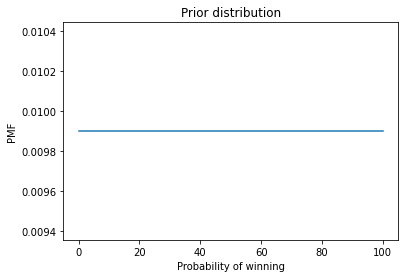

In [86]:
prior.plot()
decorate_bandit('Prior distribution')

## The Update

`xs` is an array of integers from `0` to `100` that represents different possible probabilities of winning.

* If `x` is 25, the probability of winning is 25%, so if you do win, the likelihood of that outcome was 0.25.

* If `x` is 50, the probability of winning is 50%, so if you do win, the likelihood of that outcome was 0.5.

* If `x` is 75, the probability of winning is 75%, so if you do win, the likelihood of that outcome was 0.75.

And in general, the likelihood of winning, $P(W|x)$, is `x/100` for all `x`.

In [87]:
likelihood_win = xs / 100

And the likelihood of losing, $P(L|x)$, is `1 - x/100`

In [88]:
likelihood_lose = 1 - xs/100

If we multiply the prior probabilities by the likelihood of the data, the result is the numerators of Bayes theorem, $P(x) P(W|x)$

In [89]:
numerators = prior * likelihood_win

The sum of the numerators is the denominator.

In [90]:
denominator = numerators.sum()

And we get the posterior probabilities, $P(x|W)$, by dividing through.

In [91]:
posterior = numerators / denominator

Here's what it looks like after one win.

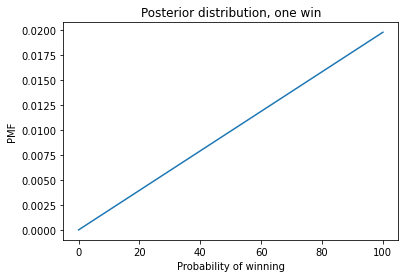

In [92]:
posterior.plot()
decorate_bandit('Posterior distribution, one win')

We can simplify that a little if we do the update in place.

The following function takes as parameters a Pandas Series that represents the prior distribution and a sequence of likelihoods.

In [93]:
def update(pmf, likelihood):
    """Likelihood function for Bayesian bandit
    
    pmf: Series that maps hypotheses to probabilities
    likelihood: sequence of likelihoods
    """
    pmf *= likelihood
    pmf /= pmf.sum()

It updates `pmf` by multiplying by the likelihood and dividing through by the probability of the data.

Here's what the posterior looks like after 1 win and one loss.

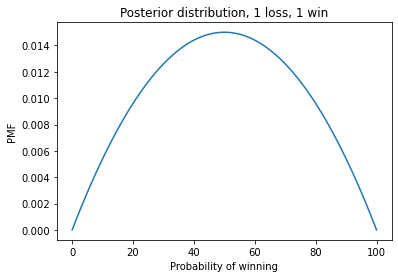

In [94]:
bandit = prior.copy()
update(bandit, likelihood_win)
update(bandit, likelihood_lose)
bandit.plot()
decorate_bandit('Posterior distribution, 1 loss, 1 win')

### Exercise

Suppose you play a machine 10 times and win once.  What is the posterior distribution of $x$?

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, suppose we have 4 machines with these probabilities:

In [95]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

For purposes of the example, we should assume that we do not know these probabilities.

The function `play` simulates playing one machine once and returns `W` or `L`.

In [96]:
from random import random
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p):
    """Return True with probability p."""
    return random() < p

def play(i):
    """Play machine i.
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [97]:
for i in range(20):
    outcome = play(3)
    print(outcome, end=' ')

L W W L W W W L W W L L L L L L W W W L 

Now I'll make four copies of the prior to represent our beliefs about the four machines.

In [98]:
beliefs = [prior.copy() for i in range(4)]

This function displays four distributions in a grid.

In [99]:
def plot(beliefs, **options):
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label='Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()

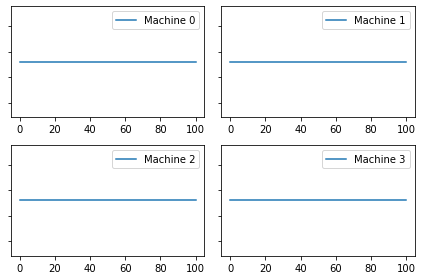

In [100]:
plot(beliefs)

As an example, let's play each machine 10 times, then plot the posterior distributions.  

In [101]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        
        if outcome == 'W':
            update(beliefs[i], likelihood_win)
        else:
            update(beliefs[i], likelihood_lose)

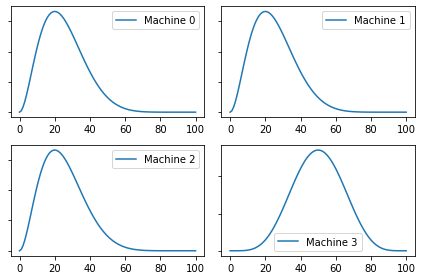

In [102]:
plot(beliefs)

After playing each machine 10 times, we can summarize `beliefs` by printing the posterior mean and credible interval:

In [103]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [104]:
from scipy.interpolate import interp1d

def credible_interval(pmf, prob):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    prob: probability of the interval
    
    return: pair of float
    """
    # make the CDF
    xs = pmf.index
    ys = pmf.cumsum()
    
    # compute the probabilities
    p = (1-prob)/2
    ps = [p, 1-p]
    
    # interpolate the inverse CDF
    options = dict(bounds_error=False,
                   fill_value=(xs[0], xs[-1]), 
                   assume_sorted=True)
    interp = interp1d(ys, xs, **options)
    return interp(ps)

In [105]:
for i, b in enumerate(beliefs):
    print(actual_probs[i]*100, pmf_mean(b), credible_interval(b, 0.9))

10.0 25.00001236675582 [ 7.36956839 46.51771062]
20.0 25.000012366755815 [ 7.36956839 46.51771062]
30.0 25.00001236675582 [ 7.36956839 46.51771062]
40.0 49.99999999999999 [26.61617958 72.38382042]


Back to the slides!

## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that it collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function draws a random outcome from the index of the `Pmf`, using the probabilities in the `Pmf` as weights. 

In [106]:
def pmf_choice(pmf):
    """Draw a random sample from a PMF.
    
    pmf: Series representing a PMF
    
    returns: quantity from PMF
    """
    return np.random.choice(pmf.index, p=pmf)

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".

In [107]:
def choose(beliefs):
    """Use the Bayesian bandit strategy to choose a machine.
    
    Draws a sample from each distributions.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [pmf_choice(b) for b in beliefs]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that chose the highest value.

Here's an example.

In [108]:
choose(beliefs)

3

## Putting it all together

In [109]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    if outcome == 'W':
        update(beliefs[machine], likelihood_win)
    else:
        update(beliefs[machine], likelihood_lose)
    
    if verbose:
        print(machine, outcome, pmf_mean(beliefs[machine]))

Here's an example

In [110]:
choose_play_update(beliefs, verbose=True)

0 L 23.076939985507135


## Trying it out

Let's start again with a fresh set of machines and an empty `Counter`.

In [111]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `beliefs` gets updated:

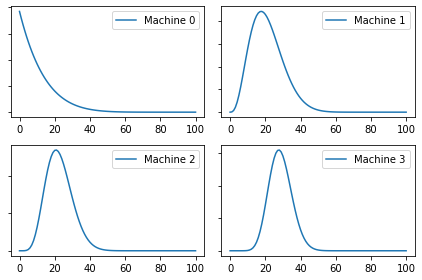

In [112]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [113]:
for i, b in enumerate(beliefs):
    print(actual_probs[i]*100, pmf_mean(b), credible_interval(b, 0.9))

10.0 10.67256304224325 [ 0.         30.40043143]
20.0 21.05261026604456 [ 7.45101245 37.17195145]
30.0 22.580645164897902 [11.00848493 35.20822933]
40.0 28.57142857142857 [18.07565584 39.07047532]


The credible intervals usually contain the true values.

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [114]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 7
1 17
2 29
3 47


### Exercise

Go back and run this section again with a different value of `num_plays` and see how it does.

## Summary

The algorithm I presented in this notebook is called [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling).  It is an example of a general strategy called [Bayesian decision theory](https://wiki.lesswrong.com/wiki/Bayesian_decision_theory), which is the idea of using a posterior distribution as part of a decision-making process, usually by choosing an action that minimizes the costs we expect on average (or maximizes a benefit).

In my opinion, strategies like this are the biggest advantage of Bayesian methods over classical statistics.  When we represent knowledge in the form of probability distributions, Bayes's theorem tells us how to change our beliefs as we get more data, and Bayesian decision theory tells us how to make that knowledge actionable.